# Flight Price Prediction EDA

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

import re
import warnings

warnings.filterwarnings(action='ignore')

In [7]:
import pandas_profiling
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV,train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [8]:
import chardet

In [15]:
with open('data/Data_Train.xlsx','rb') as fname:
          result = chardet.detect(fname.read())
print(result)

{'encoding': None, 'confidence': 0.0, 'language': None}


In [16]:
train = pd.read_excel('Data_Train.xlsx')
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [18]:
train.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

In [19]:
train['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
2 Long layover                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

We will remove the attribute **'Route'**  beacause it is not needed for the model building process

In [20]:
train.drop(['Route'],axis=1,inplace=True)

In [21]:
train.head(3)

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No info,13882


### Pandas Profiling Report

In [22]:
pandas_profiling.ProfileReport(train)

### Missing value detection and treatment

In [23]:
train.shape

(10683, 10)

In [24]:
train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [25]:
train.dropna(inplace=True)

In [26]:
train.shape

(10682, 10)

In [27]:
print(train.isnull().sum().sum())  ## to check missing values present or not

0


### Data Visualization

In [28]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,16:50,21:35,4h 45m,1 stop,No info,13302


#### 1. Count of Airlines

In [29]:
train['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

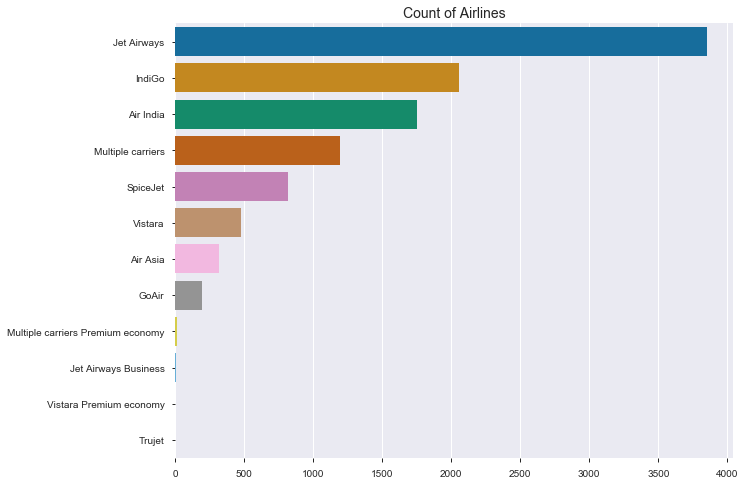

In [30]:
plt.figure(figsize=(10,8))
sns.barplot(x=train['Airline'].value_counts().values,y=train['Airline'].value_counts().index,palette='colorblind',);
plt.title('Count of Airlines',fontsize=14)
plt.show();

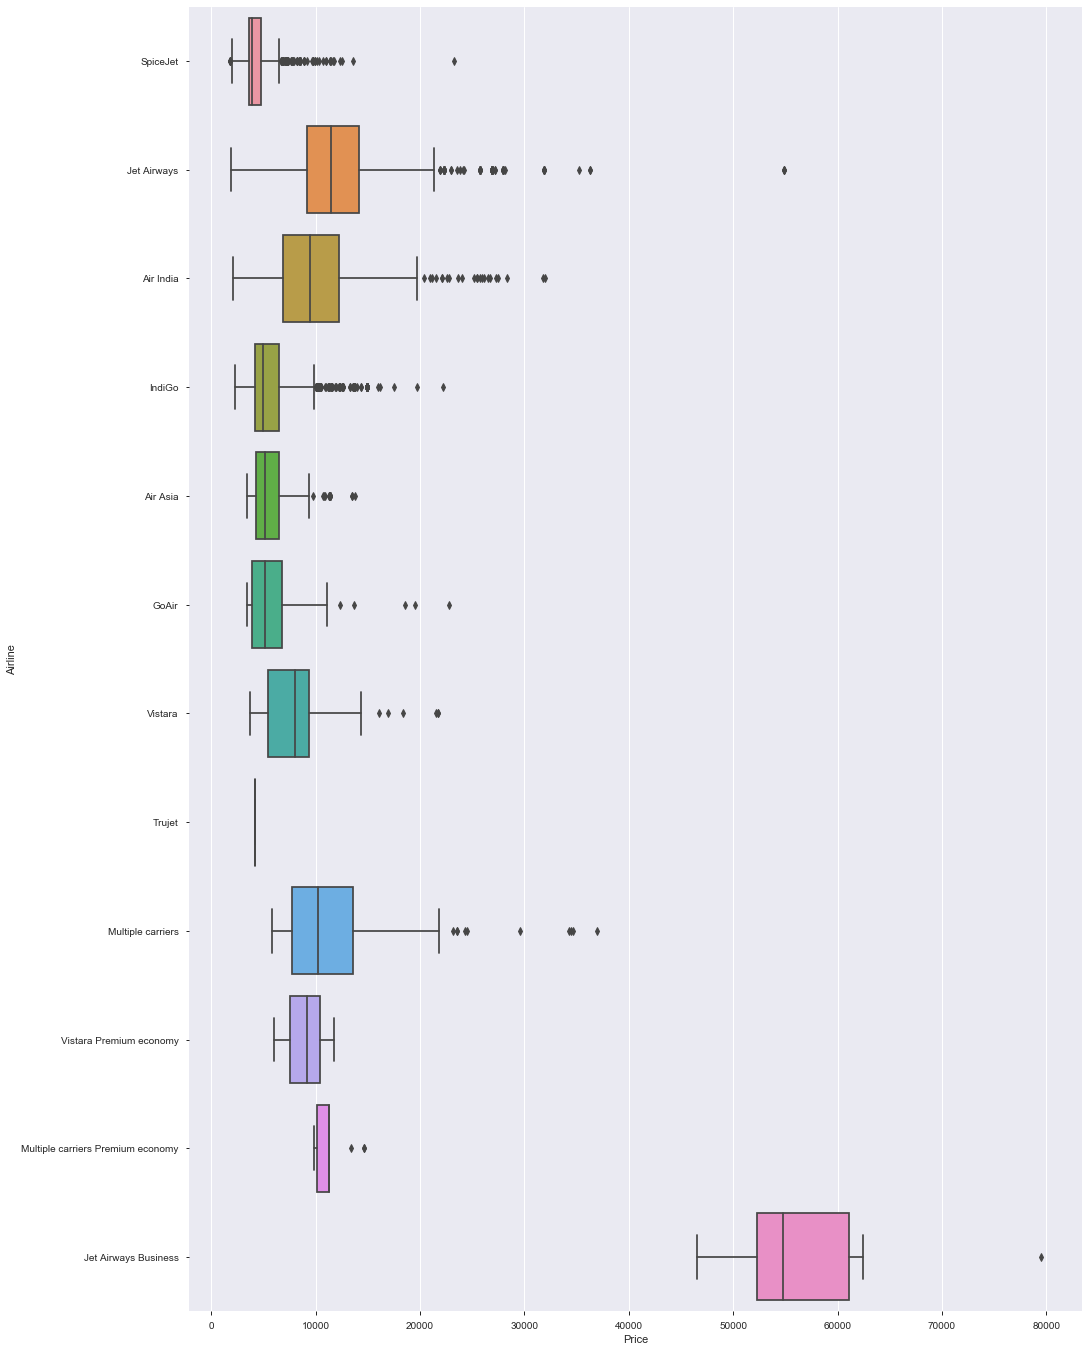

In [31]:
plt.figure(figsize=(16,24))
sns.boxplot(y='Airline',x='Price',data=train.sort_values('Price',ascending=True))
plt.show()

#### 2. Airline vs Price

In [32]:
airline_price = train.groupby('Airline')['Price'].mean().sort_values(ascending=True)
airline_price

Airline
Trujet                                4140.000000
SpiceJet                              4338.284841
Air Asia                              5590.260188
IndiGo                                5673.682903
GoAir                                 5861.056701
Vistara                               7796.348643
Vistara Premium economy               8962.333333
Air India                             9612.427756
Multiple carriers                    10902.678094
Multiple carriers Premium economy    11418.846154
Jet Airways                          11643.923357
Jet Airways Business                 58358.666667
Name: Price, dtype: float64

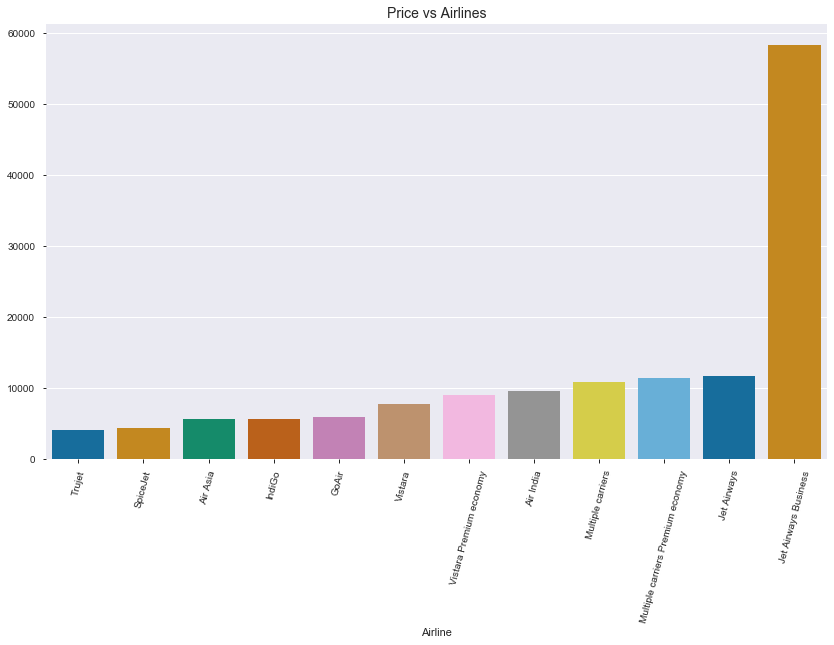

In [33]:
plt.figure(figsize=(14,8))
sns.barplot(x=airline_price.index,y=airline_price.values,palette='colorblind')
plt.xticks(rotation=75)
plt.title('Price vs Airlines',fontsize=14)
plt.show()

#### 3. Source vs Price

In [34]:
airline_source = train.groupby('Source')['Price'].mean().sort_values(ascending=True)
airline_source

Source
Chennai      4789.892388
Mumbai       5059.708752
Banglore     8017.464269
Kolkata      9158.389411
Delhi       10540.113536
Name: Price, dtype: float64

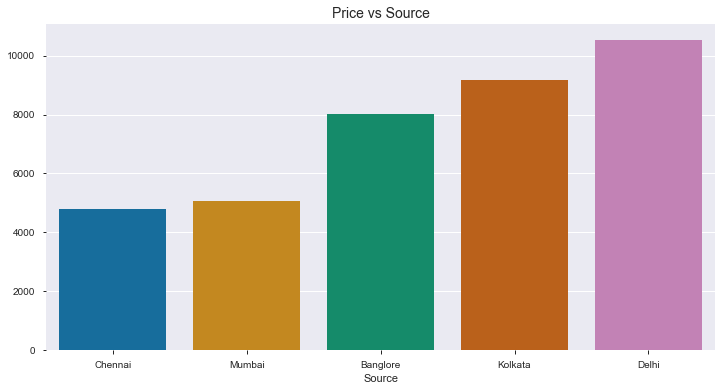

In [35]:
plt.figure(figsize=(12,6))
sns.barplot(x=airline_source.index,y=airline_source.values,palette='colorblind')
plt.title('Price vs Source',fontsize=14)
plt.show()

#### 4. Destination vs Price

In [36]:
airline_destination = train.groupby('Destination')['Price'].mean().sort_values(ascending=True)
airline_destination

Destination
Kolkata       4789.892388
Hyderabad     5059.708752
Delhi         5143.918577
Banglore      9158.389411
Cochin       10540.113536
New Delhi    11917.716738
Name: Price, dtype: float64

Here we can see that 'Delhi' & 'New Delhi' two values are present . so we can combine these 2 categories into 1 and then visualize the prices

In [37]:
train['Destination'] = train['Destination'].replace('New Delhi','Delhi')

In [38]:
airline_destination = train.groupby('Destination')['Price'].mean().sort_values(ascending=True)
airline_destination

Destination
Kolkata       4789.892388
Hyderabad     5059.708752
Delhi         8017.464269
Banglore      9158.389411
Cochin       10540.113536
Name: Price, dtype: float64

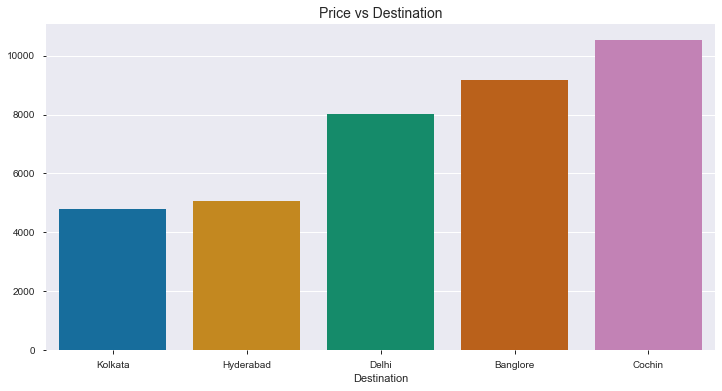

In [39]:
plt.figure(figsize=(12,6))
sns.barplot(x=airline_destination.index,y=airline_destination.values,palette='colorblind')
plt.title('Price vs Destination',fontsize=14)
plt.show()

#### 5. Price vs Stopping point

In [40]:
train['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [41]:
airline_stops = train.groupby('Total_Stops')['Price'].mean().sort_values(ascending=True)
airline_stops

Total_Stops
non-stop     5024.900315
1 stop      10594.123556
2 stops     12715.807895
3 stops     13112.000000
4 stops     17686.000000
Name: Price, dtype: float64

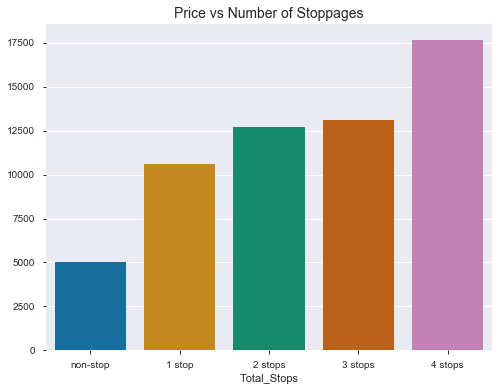

In [42]:
plt.figure(figsize=(8,6))
sns.barplot(x=airline_stops.index,y=airline_stops.values,palette='colorblind')
plt.title('Price vs Number of Stoppages',fontsize=14)
plt.show()

#### 6. Price vs Additional Info

In [43]:
train['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
2 Long layover                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

Here we can see that 'No Info' & 'No info' 2 categories are present but these represent the same feature so we will merge these

In [44]:
train['Additional_Info'] = train['Additional_Info'].replace('No info','No Info')

In [45]:
train['Additional_Info'].value_counts()

No Info                         8347
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
Red-eye flight                     1
2 Long layover                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

In [46]:
airline_adtnl_info = train.groupby('Additional_Info')['Price'].mean().sort_values(ascending=True)
airline_adtnl_info

Additional_Info
No check-in baggage included     3645.156250
No Info                          9141.125075
In-flight meal not included      9471.834511
Red-eye flight                  10873.000000
Change airports                 16800.714286
1 Long layover                  22109.631579
2 Long layover                  26480.000000
1 Short layover                 26743.000000
Business class                  56811.250000
Name: Price, dtype: float64

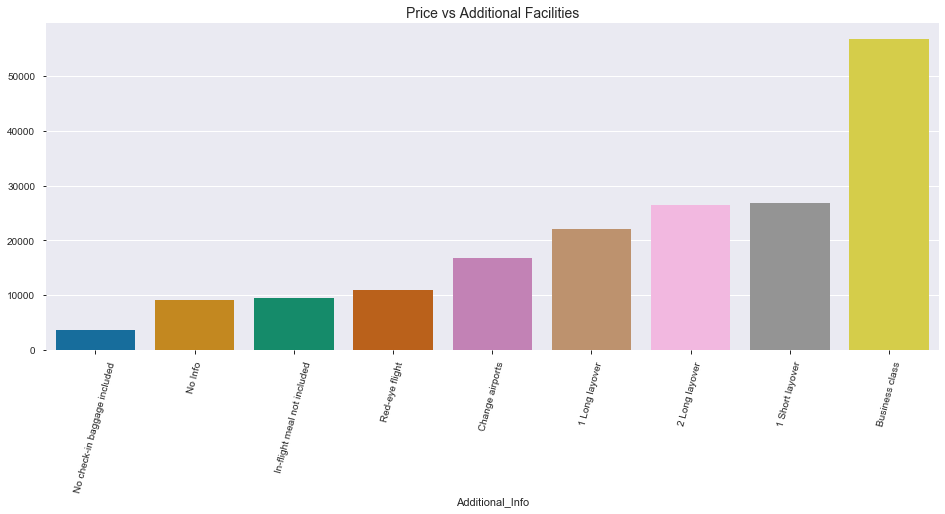

In [47]:
plt.figure(figsize=(16,6))
sns.barplot(x=airline_adtnl_info.index,y=airline_adtnl_info.values,palette='colorblind')
plt.xticks(rotation=75)
plt.title('Price vs Additional Facilities',fontsize=14)
plt.show()

#### 7.  Price for different Airlines based on Number of stoppages

In [48]:
train.groupby(['Airline','Total_Stops'])['Price'].mean()

Airline                            Total_Stops
Air Asia                           1 stop          7078.325581
                                   2 stops         6341.888889
                                   non-stop        4492.331492
Air India                          1 stop          9041.509259
                                   2 stops        12092.779101
                                   3 stops        12208.054054
                                   4 stops        17686.000000
                                   non-stop        5605.326139
GoAir                              1 stop          6884.676471
                                   non-stop        4726.173913
IndiGo                             1 stop          7104.717528
                                   2 stops         7507.526316
                                   non-stop        4731.174053
Jet Airways                        1 stop         12512.741223
                                   2 stops        13387.247467
        

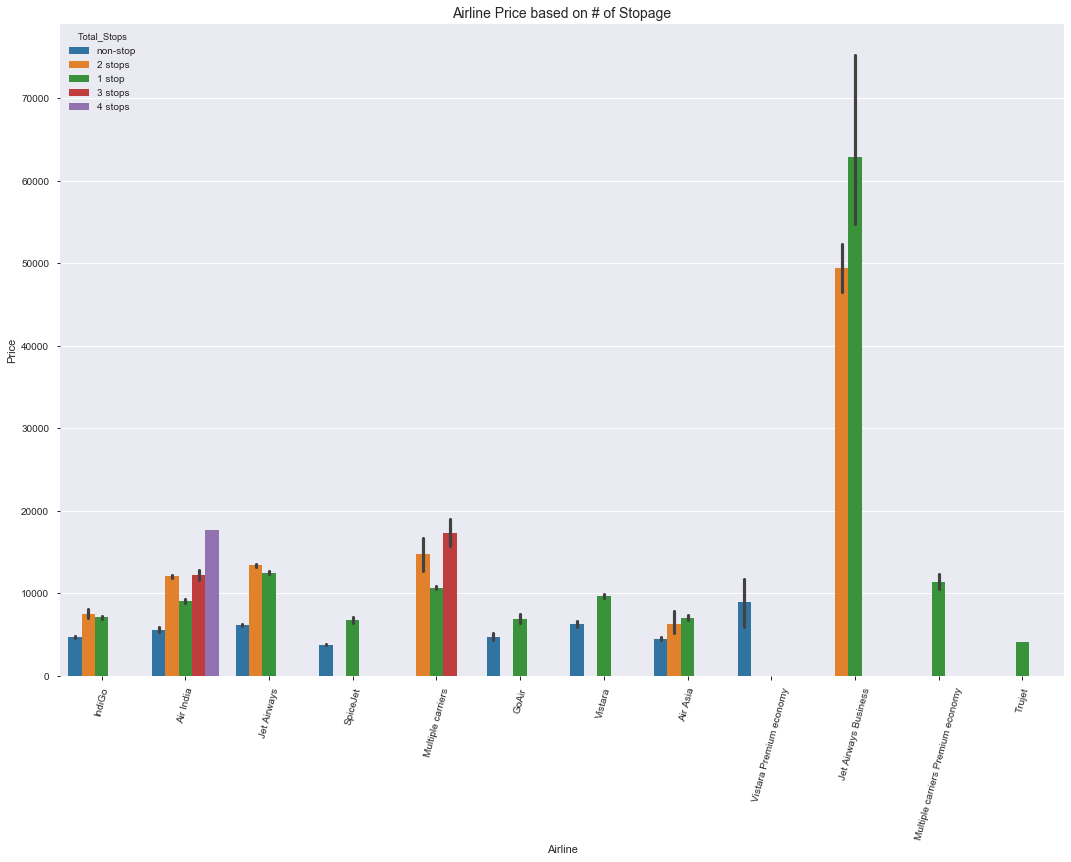

In [49]:
plt.figure(figsize=(18,12))
sns.barplot(x=train['Airline'],y=train['Price'],hue=train['Total_Stops'])
plt.xticks(rotation=75)
plt.title('Airline Price based on # of Stopage',fontsize=14)
plt.show()

### Feature Engineering

In [50]:
train.shape

(10682, 10)

In [51]:
train.head(10)

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No Info,3897
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No Info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No Info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No Info,6218
4,IndiGo,01/03/2019,Banglore,Delhi,16:50,21:35,4h 45m,1 stop,No Info,13302
5,SpiceJet,24/06/2019,Kolkata,Banglore,09:00,11:25,2h 25m,non-stop,No Info,3873
6,Jet Airways,12/03/2019,Banglore,Delhi,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087
7,Jet Airways,01/03/2019,Banglore,Delhi,08:00,05:05 02 Mar,21h 5m,1 stop,No Info,22270
8,Jet Airways,12/03/2019,Banglore,Delhi,08:55,10:25 13 Mar,25h 30m,1 stop,In-flight meal not included,11087
9,Multiple carriers,27/05/2019,Delhi,Cochin,11:25,19:15,7h 50m,1 stop,No Info,8625


Convert **Date_of_Journey** into date format

In [52]:
train['Date_of_Journey'] = pd.to_datetime(train['Date_of_Journey'])

In [53]:
train['Day_of_Journey'] = train['Date_of_Journey'].dt.day
train['Month_of_Journey'] = train['Date_of_Journey'].dt.month
train.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey
0,IndiGo,2019-03-24,Banglore,Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No Info,3897,24,3
1,Air India,2019-01-05,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No Info,7662,5,1
2,Jet Airways,2019-09-06,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No Info,13882,6,9
3,IndiGo,2019-12-05,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No Info,6218,5,12
4,IndiGo,2019-01-03,Banglore,Delhi,16:50,21:35,4h 45m,1 stop,No Info,13302,3,1


In [54]:
train['Dep_hr'] = pd.to_datetime(train['Dep_Time']).dt.hour
train['Dep_min'] = pd.to_datetime(train['Dep_Time']).dt.minute

train['Arrival_hr'] = pd.to_datetime(train['Arrival_Time']).dt.hour
train['Arrival_min'] = pd.to_datetime(train['Arrival_Time']).dt.minute

train.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arrival_hr,Arrival_min
0,IndiGo,2019-03-24,Banglore,Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No Info,3897,24,3,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No Info,7662,5,1,5,50,13,15
2,Jet Airways,2019-09-06,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No Info,13882,6,9,9,25,4,25
3,IndiGo,2019-12-05,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No Info,6218,5,12,18,5,23,30
4,IndiGo,2019-01-03,Banglore,Delhi,16:50,21:35,4h 45m,1 stop,No Info,13302,3,1,16,50,21,35


In [55]:
duration = train['Duration'].str.split(' ',expand=True)
duration.head()  

,0,1
0,2h,50m
1,7h,25m
2,19h,None
3,5h,25m
4,4h,45m


As we can see here some of the rows in minutes field are None so we will fill these None values by a dummy value then create duration_hr and duration_min features from this.

In [56]:
duration[1].fillna('00m',inplace=True)
duration.head()

,0,1
0,2h,50m
1,7h,25m
2,19h,00m
3,5h,25m
4,4h,45m


In [57]:
##replace h & m in the values

duration[0] = duration[0].str.replace('h','')
duration[0] = duration[0].str.replace('m','')  ##some records has only minutes as duration
duration[1] = duration[1].str.replace('m','')
duration.head()

,0,1
0,2,50
1,7,25
2,19,00
3,5,25
4,4,45


In [58]:
train['Duration_hr'] = duration[0].astype('int32')
train['Duration_min'] = duration[1].astype('int32')

#train['Duration_hr'].astype('int32')
#train['Duration_min'].astype('int32')

train.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hr,Duration_min
0,IndiGo,2019-03-24,Banglore,Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No Info,3897,24,3,22,20,1,10,2,50
1,Air India,2019-01-05,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No Info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,2019-09-06,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No Info,13882,6,9,9,25,4,25,19,0
3,IndiGo,2019-12-05,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No Info,6218,5,12,18,5,23,30,5,25
4,IndiGo,2019-01-03,Banglore,Delhi,16:50,21:35,4h 45m,1 stop,No Info,13302,3,1,16,50,21,35,4,45


In [59]:
## drop original columns

train.drop(['Date_of_Journey','Dep_Time','Arrival_Time','Duration'],axis=1,inplace=True)

train.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hr,Duration_min
0,IndiGo,Banglore,Delhi,non-stop,No Info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,No Info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,No Info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,No Info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1 stop,No Info,13302,3,1,16,50,21,35,4,45


#### Correlation Matrix and Heatmap

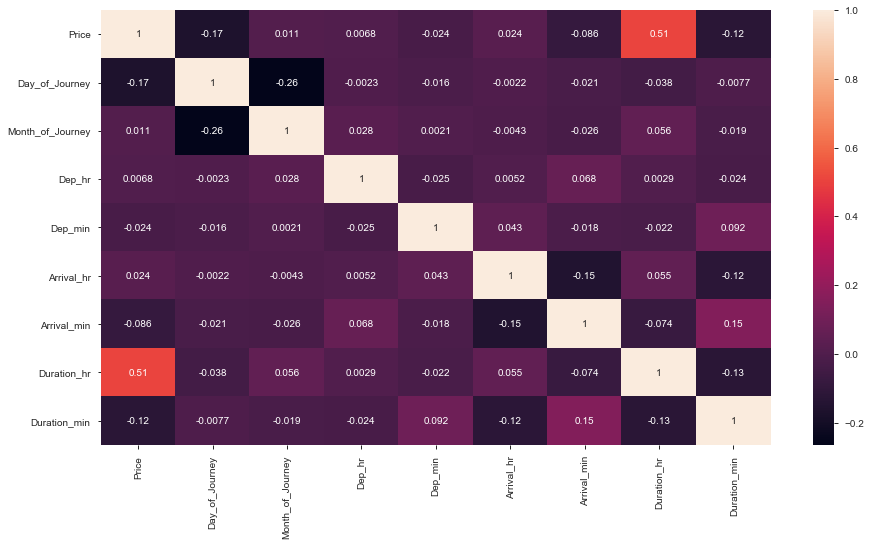

In [60]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(),annot=True)
plt.show()

#### Convert Categorical variables into numerical features

In [61]:
dummy_cols = pd.get_dummies(train[['Source','Destination','Airline','Additional_Info']],drop_first=True)
dummy_cols

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_Red-eye flight
0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10679,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10680,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10681,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [62]:
ohot_encoder = OneHotEncoder(drop='first',sparse=False,dtype='int32')
ohot_encoder.fit(train[['Airline']])
pd.DataFrame(ohot_encoder.transform(train[['Airline']]))

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10677,0,0,0,0,0,0,0,0,0,0,0
10678,1,0,0,0,0,0,0,0,0,0,0
10679,0,0,0,1,0,0,0,0,0,0,0
10680,0,0,0,0,0,0,0,0,0,1,0


In [63]:
train = pd.concat([train,dummy_cols],axis=1) ## concatenating dummy and orig dataframe

In [64]:
train['Total_Stops']=train['Total_Stops'].map({'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}) ## converting Total_Stops

train.drop(['Source','Destination','Airline','Additional_Info'],axis=1,inplace=True) # dropping orig variable

train.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hr,Duration_min,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_Red-eye flight
0,0,3897,24,3,22,20,1,10,2,50,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,7662,5,1,5,50,13,15,7,25,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,13882,6,9,9,25,4,25,19,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,6218,5,12,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,13302,3,1,16,50,21,35,4,45,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [65]:
train.shape

(10682, 37)

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   Total_Stops                                   10682 non-null  int64
 1   Price                                         10682 non-null  int64
 2   Day_of_Journey                                10682 non-null  int64
 3   Month_of_Journey                              10682 non-null  int64
 4   Dep_hr                                        10682 non-null  int64
 5   Dep_min                                       10682 non-null  int64
 6   Arrival_hr                                    10682 non-null  int64
 7   Arrival_min                                   10682 non-null  int64
 8   Duration_hr                                   10682 non-null  int32
 9   Duration_min                                  10682 non-null  int32
 10  Source_Che

### Feature Engineering on test dataset

In [67]:
test = pd.read_excel('Test_set.xlsx')
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


Now we will apply same set of transformations and feature engg. on test dataset

##### Date_of_Journey

In [69]:
test['Day_of_Journey'] = pd.to_datetime(test['Date_of_Journey']).dt.day
test['Month_of_Journey'] = pd.to_datetime(test['Date_of_Journey']).dt.month


##### Creating dummy feature for Source & Destination & Airline & Additional_Info  

In [70]:
test['Source'].value_counts()

Delhi       1145
Kolkata      710
Banglore     555
Mumbai       186
Chennai       75
Name: Source, dtype: int64

In [71]:
test['Destination'].value_counts()

Cochin       1145
Banglore      710
Delhi         317
New Delhi     238
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64

In [72]:
test['Destination'] = test['Destination'].str.replace('New Delhi','Delhi') ## replacing 'New Delhi' with 'Delhi'
test['Destination'].value_counts()

Cochin       1145
Banglore      710
Delhi         555
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64

In [73]:
test['Airline'].value_counts()

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Jet Airways Business                   2
Vistara Premium economy                2
Name: Airline, dtype: int64

In [74]:
test['Additional_Info'].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
1 Long layover                     1
Change airports                    1
Business class                     1
Name: Additional_Info, dtype: int64

In [75]:
test_dummy_cols = pd.get_dummies(test[['Source','Destination','Airline','Additional_Info']],drop_first=True)
test_dummy_cols

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info
0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2667,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2668,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2669,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [76]:
test['Total_Stops'].value_counts()

1 stop      1431
non-stop     849
2 stops      379
3 stops       11
4 stops        1
Name: Total_Stops, dtype: int64

In [77]:
test['Total_Stops']=test['Total_Stops'].map({'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}) ## converting Total_Stops

##### Dep_Time & Arrival_Time

In [78]:
test['Dep_hr'] = pd.to_datetime(test['Dep_Time']).dt.hour
test['Dep_min'] = pd.to_datetime(test['Dep_Time']).dt.minute

test['Arrival_hr'] = pd.to_datetime(test['Arrival_Time']).dt.hour
test['Arrival_min'] = pd.to_datetime(test['Arrival_Time']).dt.minute

##### Duration

In [79]:
test_duration = test['Duration'].str.split(' ',expand=True)
test_duration.head(3)

,0,1
0,10h,55m
1,4h,None
2,23h,45m


In [80]:
test_duration.fillna('00m',inplace=True)
test_duration
test_duration.head(3)

,0,1
0,10h,55m
1,4h,00m
2,23h,45m


In [81]:
##replace h & m in the values

test_duration[0] = test_duration[0].str.replace('h','')
test_duration[0] = test_duration[0].str.replace('m','')  ##some records has only minutes as duration
test_duration[1] = test_duration[1].str.replace('m','')
test_duration.head()

,0,1
0,10,55
1,4,00
2,23,45
3,13,00
4,2,50


In [82]:
test['Duration_hr'] = test_duration[0].astype('int32')
test['Duration_min'] = test_duration[1].astype('int32')

#train['Duration_hr'].astype('int32')
#train['Duration_min'].astype('int32')

test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hr,Duration_min
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1,No info,6,6,17,30,4,25,10,55
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1,No info,5,12,6,20,10,20,4,0
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1,In-flight meal not included,21,5,19,15,19,0,23,45
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1,No info,21,5,8,0,21,0,13,0
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,0,No info,24,6,23,55,2,45,2,50


In [83]:
## dropping orig and unncessary variables

test.drop(['Airline','Date_of_Journey','Source','Destination','Route','Dep_Time','Arrival_Time','Duration','Additional_Info'],axis=1,inplace=True)

In [84]:
## concatenating dummy dataframe and orig test datafram
test = pd.concat([test,test_dummy_cols],axis=1)
test.head()

,Total_Stops,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hr,Duration_min,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info
0,1,6,6,17,30,4,25,10,55,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,5,12,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,1,21,5,19,15,19,0,23,45,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,1,21,5,8,0,21,0,13,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [85]:
print(train.shape)
print(test.shape)

(10682, 37)
(2671, 32)


In [86]:
train.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arrival_hr,Arrival_min,Duration_hr,Duration_min,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_Red-eye flight
0,0,3897,24,3,22,20,1,10,2,50,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,7662,5,1,5,50,13,15,7,25,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,13882,6,9,9,25,4,25,19,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,6218,5,12,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,13302,3,1,16,50,21,35,4,45,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Train Test data split

In [87]:
x = train.drop('Price',axis=1)
y = train['Price']

In [88]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=101)

print("train dataset shape : ",x_train.shape)
print("train dataset shape : ",y_train.shape)
print("test dataset shape : ",x_test.shape)
print("test dataset shape : ",y_test.shape)

train dataset shape :  (8011, 36)
train dataset shape :  (8011,)
test dataset shape :  (2671, 36)
test dataset shape :  (2671,)


### Model Building

##### 1. Linear Regression

In [89]:
%%time
LR_model = LinearRegression()
LR_model.fit(x_train,y_train)

Wall time: 169 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
y_train_pred = LR_model.predict(x_train)
y_test_pred = LR_model.predict(x_test)


print("Mean value of Price : ",train['Price'].mean())
print("***********************************************")

print("Train score : ",r2_score(y_train,y_train_pred)*100)
print("Test Score : ",r2_score(y_test,y_test_pred)*100)
print("***********************************************")

print("RMSE for train : ",np.sqrt(mean_squared_error(y_train,y_train_pred))*100)
print("RMSE for test : ",np.sqrt(mean_squared_error(y_test,y_test_pred))*100)
print("***********************************************")

print("MAE for train : ",mean_absolute_error(y_train,y_train_pred)*100)
print("MAE for test : ",mean_absolute_error(y_test,y_test_pred)*100)

Mean value of Price :  9087.21456656057
***********************************************
Train score :  67.0458281504318
Test Score :  65.87509735478649
***********************************************
RMSE for train :  265420.9268014139
RMSE for test :  267196.4665315665
***********************************************
MAE for train :  181205.31142134368
MAE for test :  179514.71242421275


##### 2. RandomForest Model

In [91]:
%%time
RF_model = RandomForestRegressor()
RF_model.fit(x_train,y_train)

Wall time: 3.89 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [92]:
y_train_pred = RF_model.predict(x_train)
y_test_pred = RF_model.predict(x_test)


print("Mean value of Price : ",train['Price'].mean())
print("***********************************************")

print("Train score : ",r2_score(y_train,y_train_pred)*100)
print("Test Score : ",r2_score(y_test,y_test_pred)*100)
print("***********************************************")

print("RMSE for train : ",np.sqrt(mean_squared_error(y_train,y_train_pred))*100)
print("RMSE for test : ",np.sqrt(mean_squared_error(y_test,y_test_pred))*100)
print("***********************************************")

print("MAE for train : ",mean_absolute_error(y_train,y_train_pred)*100)
print("MAE for test : ",mean_absolute_error(y_test,y_test_pred)*100)

Mean value of Price :  9087.21456656057
***********************************************
Train score :  97.95173213943428
Test Score :  90.33364486667806
***********************************************
RMSE for train :  66171.85897567055
RMSE for test :  142208.76781698063
***********************************************
MAE for train :  27314.465470300307
MAE for test :  66230.9860408384


##### 3. ExtraTree Model

In [93]:
%%time
ET_model = ExtraTreesRegressor()
ET_model.fit(x_train,y_train)

Wall time: 3.41 s


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [94]:
y_train_pred = ET_model.predict(x_train)
y_test_pred = ET_model.predict(x_test)


print("Mean value of Price : ",train['Price'].mean())
print("***********************************************")

print("Train score : ",r2_score(y_train,y_train_pred)*100)
print("Test Score : ",r2_score(y_test,y_test_pred)*100)
print("***********************************************")

print("RMSE for train : ",np.sqrt(mean_squared_error(y_train,y_train_pred))*100)
print("RMSE for test : ",np.sqrt(mean_squared_error(y_test,y_test_pred))*100)
print("***********************************************")

print("MAE for train : ",mean_absolute_error(y_train,y_train_pred)*100)
print("MAE for test : ",mean_absolute_error(y_test,y_test_pred)*100)

Mean value of Price :  9087.21456656057
***********************************************
Train score :  99.6234851153684
Test Score :  90.80569833464676
***********************************************
RMSE for train :  28370.764259236745
RMSE for test :  138692.94643375458
***********************************************
MAE for train :  3779.0346606749054
MAE for test :  65608.5207412954


##### 4. XGBoost Model

In [95]:
%%time
XG_model = XGBRegressor()
XG_model.fit(x_train,y_train)

[03:36:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 875 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [96]:
y_train_pred = XG_model.predict(x_train)
y_test_pred = XG_model.predict(x_test)


print("Mean value of Price : ",train['Price'].mean())
print("***********************************************")

print("Train score : ",r2_score(y_train,y_train_pred)*100)
print("Test Score : ",r2_score(y_test,y_test_pred)*100)
print("***********************************************")

print("RMSE for train : ",np.sqrt(mean_squared_error(y_train,y_train_pred))*100)
print("RMSE for test : ",np.sqrt(mean_squared_error(y_test,y_test_pred))*100)
print("***********************************************")

print("MAE for train : ",mean_absolute_error(y_train,y_train_pred)*100)
print("MAE for test : ",mean_absolute_error(y_test,y_test_pred)*100)

Mean value of Price :  9087.21456656057
***********************************************
Train score :  83.22870431613501
Test Score :  81.73296387087565
***********************************************
RMSE for train :  189349.10999784007
RMSE for test :  195492.02441731925
***********************************************
MAE for train :  124672.99397837251
MAE for test :  125135.89081530356


##### 5. CatBoost Model

In [97]:
%%time
CB_model = CatBoostRegressor()
CB_model.fit(x_train,y_train)

Learning rate set to 0.056527
0:	learn: 4456.3834505	total: 144ms	remaining: 2m 23s
1:	learn: 4309.1429983	total: 152ms	remaining: 1m 15s
2:	learn: 4160.1255976	total: 160ms	remaining: 53.3s
3:	learn: 4017.3365505	total: 169ms	remaining: 42s
4:	learn: 3890.1386120	total: 177ms	remaining: 35.2s
5:	learn: 3767.9626615	total: 185ms	remaining: 30.7s
6:	learn: 3649.2697963	total: 192ms	remaining: 27.2s
7:	learn: 3557.6832029	total: 199ms	remaining: 24.6s
8:	learn: 3461.7684853	total: 206ms	remaining: 22.7s
9:	learn: 3368.5125349	total: 214ms	remaining: 21.2s
10:	learn: 3284.5419072	total: 221ms	remaining: 19.9s
11:	learn: 3202.8500833	total: 231ms	remaining: 19s
12:	learn: 3129.9690995	total: 238ms	remaining: 18.1s
13:	learn: 3066.2751569	total: 247ms	remaining: 17.4s
14:	learn: 3000.6863635	total: 255ms	remaining: 16.7s
15:	learn: 2944.9728901	total: 263ms	remaining: 16.2s
16:	learn: 2888.3785355	total: 270ms	remaining: 15.6s
17:	learn: 2840.3152150	total: 277ms	remaining: 15.1s
18:	learn:

188:	learn: 1716.8995368	total: 946ms	remaining: 4.06s
189:	learn: 1714.0708995	total: 949ms	remaining: 4.05s
190:	learn: 1710.6907925	total: 953ms	remaining: 4.04s
191:	learn: 1710.2616555	total: 956ms	remaining: 4.03s
192:	learn: 1707.9048802	total: 960ms	remaining: 4.01s
193:	learn: 1707.6285146	total: 963ms	remaining: 4s
194:	learn: 1706.8829462	total: 967ms	remaining: 3.99s
195:	learn: 1706.2789976	total: 971ms	remaining: 3.98s
196:	learn: 1706.0170472	total: 974ms	remaining: 3.97s
197:	learn: 1704.1696628	total: 977ms	remaining: 3.96s
198:	learn: 1702.1655776	total: 982ms	remaining: 3.95s
199:	learn: 1700.0658806	total: 985ms	remaining: 3.94s
200:	learn: 1699.6772831	total: 988ms	remaining: 3.93s
201:	learn: 1697.4929968	total: 991ms	remaining: 3.92s
202:	learn: 1697.1246760	total: 995ms	remaining: 3.91s
203:	learn: 1696.9275701	total: 998ms	remaining: 3.89s
204:	learn: 1694.1840360	total: 1s	remaining: 3.88s
205:	learn: 1690.9226656	total: 1s	remaining: 3.87s
206:	learn: 1687.62

387:	learn: 1457.5647250	total: 1.59s	remaining: 2.51s
388:	learn: 1456.3432587	total: 1.6s	remaining: 2.51s
389:	learn: 1456.0726290	total: 1.6s	remaining: 2.5s
390:	learn: 1456.0203218	total: 1.6s	remaining: 2.5s
391:	learn: 1454.5270110	total: 1.6s	remaining: 2.49s
392:	learn: 1454.4763179	total: 1.61s	remaining: 2.48s
393:	learn: 1453.9122918	total: 1.61s	remaining: 2.48s
394:	learn: 1453.4379603	total: 1.61s	remaining: 2.47s
395:	learn: 1451.9240640	total: 1.62s	remaining: 2.47s
396:	learn: 1450.4541771	total: 1.62s	remaining: 2.46s
397:	learn: 1449.9312457	total: 1.63s	remaining: 2.46s
398:	learn: 1449.2816569	total: 1.63s	remaining: 2.45s
399:	learn: 1448.1250980	total: 1.63s	remaining: 2.45s
400:	learn: 1446.8471802	total: 1.64s	remaining: 2.44s
401:	learn: 1445.6922996	total: 1.64s	remaining: 2.44s
402:	learn: 1444.2629015	total: 1.65s	remaining: 2.44s
403:	learn: 1444.2369747	total: 1.65s	remaining: 2.43s
404:	learn: 1444.2121439	total: 1.65s	remaining: 2.43s
405:	learn: 1443

570:	learn: 1300.0314390	total: 2.23s	remaining: 1.67s
571:	learn: 1299.1282256	total: 2.23s	remaining: 1.67s
572:	learn: 1298.4781687	total: 2.23s	remaining: 1.66s
573:	learn: 1297.2893499	total: 2.24s	remaining: 1.66s
574:	learn: 1296.6590751	total: 2.24s	remaining: 1.66s
575:	learn: 1295.7030761	total: 2.24s	remaining: 1.65s
576:	learn: 1295.2817899	total: 2.25s	remaining: 1.65s
577:	learn: 1293.8724137	total: 2.25s	remaining: 1.64s
578:	learn: 1292.7426692	total: 2.25s	remaining: 1.64s
579:	learn: 1291.8377877	total: 2.26s	remaining: 1.64s
580:	learn: 1290.7007353	total: 2.26s	remaining: 1.63s
581:	learn: 1289.8820381	total: 2.27s	remaining: 1.63s
582:	learn: 1289.5403851	total: 2.27s	remaining: 1.62s
583:	learn: 1288.9507714	total: 2.27s	remaining: 1.62s
584:	learn: 1287.8411535	total: 2.28s	remaining: 1.61s
585:	learn: 1287.4780991	total: 2.28s	remaining: 1.61s
586:	learn: 1286.7167187	total: 2.28s	remaining: 1.61s
587:	learn: 1286.6745641	total: 2.29s	remaining: 1.6s
588:	learn:

765:	learn: 1167.3241898	total: 2.87s	remaining: 876ms
766:	learn: 1167.2879140	total: 2.88s	remaining: 874ms
767:	learn: 1166.9462386	total: 2.88s	remaining: 870ms
768:	learn: 1166.0385704	total: 2.88s	remaining: 866ms
769:	learn: 1165.3860809	total: 2.89s	remaining: 862ms
770:	learn: 1164.9604866	total: 2.89s	remaining: 858ms
771:	learn: 1164.7606571	total: 2.89s	remaining: 854ms
772:	learn: 1164.5817150	total: 2.9s	remaining: 851ms
773:	learn: 1163.4373113	total: 2.9s	remaining: 847ms
774:	learn: 1162.5076515	total: 2.9s	remaining: 843ms
775:	learn: 1162.4816321	total: 2.91s	remaining: 839ms
776:	learn: 1161.9797441	total: 2.91s	remaining: 835ms
777:	learn: 1161.1657019	total: 2.91s	remaining: 831ms
778:	learn: 1161.1425719	total: 2.92s	remaining: 827ms
779:	learn: 1160.5190613	total: 2.92s	remaining: 824ms
780:	learn: 1160.4770919	total: 2.92s	remaining: 820ms
781:	learn: 1160.3265845	total: 2.92s	remaining: 816ms
782:	learn: 1159.7409754	total: 2.93s	remaining: 812ms
783:	learn: 1

963:	learn: 1083.3012976	total: 3.51s	remaining: 131ms
964:	learn: 1082.5203764	total: 3.52s	remaining: 128ms
965:	learn: 1081.7203451	total: 3.52s	remaining: 124ms
966:	learn: 1080.6151501	total: 3.52s	remaining: 120ms
967:	learn: 1079.9798452	total: 3.53s	remaining: 117ms
968:	learn: 1078.9806344	total: 3.53s	remaining: 113ms
969:	learn: 1078.2630420	total: 3.53s	remaining: 109ms
970:	learn: 1077.6660704	total: 3.54s	remaining: 106ms
971:	learn: 1077.0597443	total: 3.54s	remaining: 102ms
972:	learn: 1076.8611137	total: 3.54s	remaining: 98.3ms
973:	learn: 1076.5945557	total: 3.55s	remaining: 94.7ms
974:	learn: 1076.4922582	total: 3.55s	remaining: 91ms
975:	learn: 1075.5056658	total: 3.55s	remaining: 87.4ms
976:	learn: 1074.8242535	total: 3.56s	remaining: 83.8ms
977:	learn: 1073.9237711	total: 3.56s	remaining: 80.1ms
978:	learn: 1073.5944929	total: 3.56s	remaining: 76.5ms
979:	learn: 1073.0821859	total: 3.57s	remaining: 72.8ms
980:	learn: 1072.6857413	total: 3.57s	remaining: 69.2ms
981

In [98]:
y_train_pred = CB_model.predict(x_train)
y_test_pred = CB_model.predict(x_test)


print("Mean value of Price : ",train['Price'].mean())
print("***********************************************")

print("Train score : ",r2_score(y_train,y_train_pred)*100)
print("Test Score : ",r2_score(y_test,y_test_pred)*100)
print("***********************************************")

print("RMSE for train : ",np.sqrt(mean_squared_error(y_train,y_train_pred))*100)
print("RMSE for test : ",np.sqrt(mean_squared_error(y_test,y_test_pred))*100)
print("***********************************************")

print("MAE for train : ",mean_absolute_error(y_train,y_train_pred)*100)
print("MAE for test : ",mean_absolute_error(y_test,y_test_pred)*100)

Mean value of Price :  9087.21456656057
***********************************************
Train score :  94.70912611556356
Test Score :  90.01237307193871
***********************************************
RMSE for train :  106351.5111214985
RMSE for test :  144552.68267041273
***********************************************
MAE for train :  68551.14320105327
MAE for test :  82482.76748935498


##### 6. LGBM Model

In [99]:
%%time
LG_model = LGBMRegressor()
LG_model.fit(x_train,y_train)

Wall time: 345 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [100]:
y_train_pred = LG_model.predict(x_train)
y_test_pred = LG_model.predict(x_test)


print("Mean value of Price : ",train['Price'].mean())
print("***********************************************")

print("Train score : ",r2_score(y_train,y_train_pred)*100)
print("Test Score : ",r2_score(y_test,y_test_pred)*100)
print("***********************************************")

print("RMSE for train : ",np.sqrt(mean_squared_error(y_train,y_train_pred))*100)
print("RMSE for test : ",np.sqrt(mean_squared_error(y_test,y_test_pred))*100)
print("***********************************************")

print("MAE for train : ",mean_absolute_error(y_train,y_train_pred)*100)
print("MAE for test : ",mean_absolute_error(y_test,y_test_pred)*100)

Mean value of Price :  9087.21456656057
***********************************************
Train score :  90.8757756446666
Test Score :  87.70459121529768
***********************************************
RMSE for train :  139661.897438984
RMSE for test :  160386.01106052837
***********************************************
MAE for train :  80638.93457151155
MAE for test :  90378.40072694061


CatBoost Model has perform significantly for both train and test . so we will take this model as final model

### Save Dataset

In [101]:
train.to_csv('flight-data-cleaned.csv')